https://medium.com/analytics-vidhya/predicting-stock-prices-using-facebooks-prophet-model-b1716c733ea6#:~:text=Prophet%20is%20a%20procedure%20for,daily%20seasonality%2C%20plus%20holiday%20effects.&text=with%2C%20g(t)%20representing,linear%20model%20for%20trend%20forecasting.

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
df = pd.read_csv("df1.csv", parse_dates=['Date'])
# df.head()

In [2]:
df = df[["Date","Close"]] 
# Rename the features: These names are required for the model fitting
df = df.rename(columns = {"Date":"ds","Close":"y"}) 
# df.head()

In [3]:
from datetime import datetime
cutoff = datetime(2020,1,1)
df_train = df.loc[df.ds < cutoff,].copy()
df_test = df.drop(df_train.index).copy()
# df_train

In [4]:
from fbprophet import Prophet
fbp = Prophet(daily_seasonality = True) 
fbp.fit(df_train)
# We need to specify the number of days in future
# We'll be predicting the full 2021 stock prices
fut = fbp.make_future_dataframe(periods=365) 
forecast = fbp.predict(fut)

In [5]:
fc_train = forecast.loc[forecast.ds < cutoff,].copy()
fc_test = forecast.drop(fc_train.index).copy()

In [6]:
# if len(fc_train.ds) == len(df_train.ds):
#     print(True)
# else:
#     print(False)
# print('check')
# if len(fc_test.ds) == len(df_test.ds):
#     print(True)
# else:
#     print(False)

In [7]:
dt = pd.date_range(start=df_test.ds.iloc[-1], periods=600, freq="D")
dt

DatetimeIndex(['2020-01-02', '2020-01-03', '2020-01-04', '2020-01-05',
               '2020-01-06', '2020-01-07', '2020-01-08', '2020-01-09',
               '2020-01-10', '2020-01-11',
               ...
               '2021-08-14', '2021-08-15', '2021-08-16', '2021-08-17',
               '2021-08-18', '2021-08-19', '2021-08-20', '2021-08-21',
               '2021-08-22', '2021-08-23'],
              dtype='datetime64[ns]', length=600, freq='D')

In [8]:
import trading_calendars as tc
import pandas as pd
import pytz

xnys = tc.get_calendar('XNYS')
trading_days = [x for x in dt if xnys.is_session(x)]
trading_days = trading_days[: len(fc_test)]
d= {'ds':trading_days, 'yhat': fc_test.yhat.to_numpy(), 'yhat_lower': fc_test.yhat_lower.to_numpy(), 'yhat_upper':fc_test.yhat_upper.to_numpy() }
pred = pd.DataFrame(data=d )


<ipython-input-8-b45efc90b54d>:6: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  trading_days = [x for x in dt if xnys.is_session(x)]


In [10]:
m = min(len(df_test.y), len(pred.yhat), 252)
m

252

In [11]:
from sklearn.metrics import mean_squared_error as MSE
mse_train = MSE(fc_train.yhat,df_train.y)
mse_test = MSE(pred.yhat[:m], df_test.y[:m])
print(mse_train, mse_test)    

1188161.350178112 165127.72611702493


In [33]:
pred

,ds,yhat,yhat_lower,yhat_upper
0,2020-01-02,3094.573514,3018.297327,3170.048458
1,2020-01-03,3095.882465,3017.618571,3169.606208
2,2020-01-06,3096.626962,3029.704421,3169.528854
3,2020-01-07,3103.108302,3028.262436,3177.413314
4,2020-01-08,3103.866636,3027.986218,3176.773834
...,...,...,...,...
360,2021-06-08,3364.488950,3158.525776,3567.069149
361,2021-06-09,3365.081808,3159.124309,3589.592097
362,2021-06-10,3358.753972,3141.137360,3584.395056
363,2021-06-11,3361.394184,3145.568620,3575.675159


In [9]:
fc_train = fc_train[['ds','yhat', 'yhat_lower', 'yhat_upper']]

In [10]:
pred = fc_train.append(pred)
pred.tail(20)

,ds,yhat,yhat_lower,yhat_upper
345,2021-05-17,3350.499178,3138.286359,3548.683594
346,2021-05-18,3357.076954,3148.582698,3557.387503
347,2021-05-19,3357.857707,3148.300303,3537.003374
348,2021-05-20,3351.596375,3131.000922,3532.834597
349,2021-05-21,3354.191714,3134.070932,3545.765903
350,2021-05-24,3353.523007,3131.945744,3539.913602
351,2021-05-25,3354.583340,3133.174467,3549.069525
352,2021-05-26,3355.030015,3123.589405,3536.016957
353,2021-05-27,3361.187425,3120.694747,3576.472600
354,2021-05-28,3361.619609,3135.704223,3549.625349


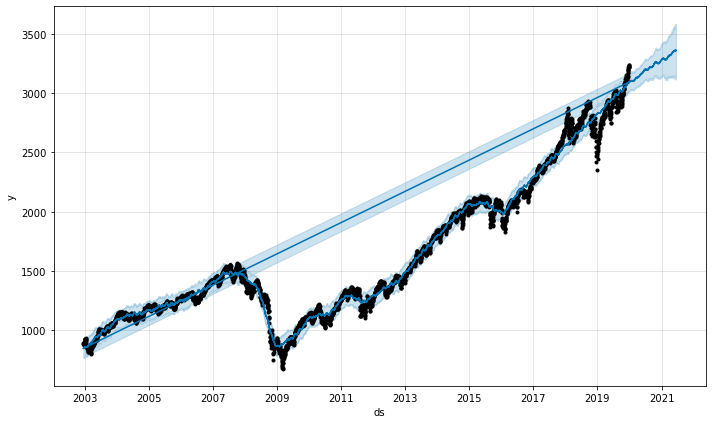

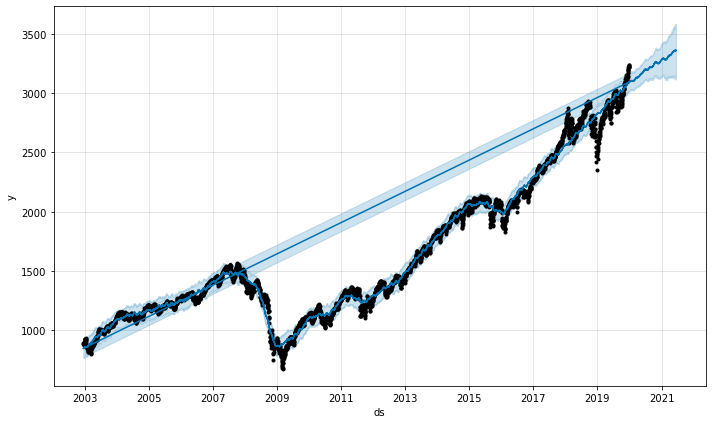

In [167]:
from fbprophet.plot import plot
# A better plot than the simple matplotlib
plot(fbp, pred)
# MSE(pred.yhat[:len(df.y)],df.y)

In [145]:
weekend = [x for x in dt if x.date().weekday() % 7 == 6 or x.date().weekday() % 7 == 0]
# weekend

In [146]:
for i in range(len(dt)-len(us_holidays) - len(weekend)):
    if dt[i] in us_holidays or dt[i] in weekend:
        dt=dt.delete(i)
        

In [151]:
df.ds.head(50)

0    2021-01-29
1    2021-01-28
2    2021-01-27
3    2021-01-26
4    2021-01-25
5    2021-01-22
6    2021-01-21
7    2021-01-20
8    2021-01-19
9    2021-01-15
10   2021-01-14
11   2021-01-13
12   2021-01-12
13   2021-01-11
14   2021-01-08
15   2021-01-07
16   2021-01-06
17   2021-01-05
18   2021-01-04
19   2020-12-31
20   2020-12-30
21   2020-12-29
22   2020-12-28
23   2020-12-24
24   2020-12-23
25   2020-12-22
26   2020-12-21
27   2020-12-18
28   2020-12-17
29   2020-12-16
30   2020-12-15
31   2020-12-14
32   2020-12-11
33   2020-12-10
34   2020-12-09
35   2020-12-08
36   2020-12-07
37   2020-12-04
38   2020-12-03
39   2020-12-02
40   2020-12-01
41   2020-11-30
42   2020-11-27
43   2020-11-25
44   2020-11-24
45   2020-11-23
46   2020-11-20
47   2020-11-19
48   2020-11-18
49   2020-11-17
Name: ds, dtype: datetime64[ns]

In [152]:
dt[-50:]


DatetimeIndex(['2020-12-11', '2020-12-12', '2020-12-13', '2020-12-14',
               '2020-12-15', '2020-12-16', '2020-12-17', '2020-12-18',
               '2020-12-19', '2020-12-20', '2020-12-21', '2020-12-22',
               '2020-12-23', '2020-12-24', '2020-12-25', '2020-12-26',
               '2020-12-27', '2020-12-28', '2020-12-29', '2020-12-30',
               '2020-12-31', '2021-01-01', '2021-01-02', '2021-01-03',
               '2021-01-04', '2021-01-05', '2021-01-06', '2021-01-07',
               '2021-01-08', '2021-01-09', '2021-01-10', '2021-01-11',
               '2021-01-12', '2021-01-13', '2021-01-14', '2021-01-15',
               '2021-01-16', '2021-01-17', '2021-01-18', '2021-01-19',
               '2021-01-20', '2021-01-21', '2021-01-22', '2021-01-23',
               '2021-01-24', '2021-01-25', '2021-01-26', '2021-01-27',
               '2021-01-28', '2021-01-29'],
              dtype='datetime64[ns]', freq=None)

In [131]:
dt[4].date().weekday() % 7

0

In [102]:
dt.delete(0)

DatetimeIndex(['2020-01-03', '2020-01-04', '2020-01-05', '2020-01-06',
               '2020-01-07', '2020-01-08', '2020-01-09', '2020-01-10',
               '2020-01-11', '2020-01-12',
               ...
               '2021-01-26', '2021-01-27', '2021-01-28', '2021-01-29',
               '2021-01-30', '2021-01-31', '2021-02-01', '2021-02-02',
               '2021-02-03', '2021-02-04'],
              dtype='datetime64[ns]', length=399, freq='D')

In [98]:
holi = [pd.Timestamp(x) for x in dt if x in us_holidays]
holi

[Timestamp('2020-01-20 00:00:00', freq='D'),
 Timestamp('2020-02-17 00:00:00', freq='D'),
 Timestamp('2020-05-25 00:00:00', freq='D'),
 Timestamp('2020-07-03 00:00:00', freq='D'),
 Timestamp('2020-07-04 00:00:00', freq='D'),
 Timestamp('2020-09-07 00:00:00', freq='D'),
 Timestamp('2020-10-12 00:00:00', freq='D'),
 Timestamp('2020-11-11 00:00:00', freq='D'),
 Timestamp('2020-11-26 00:00:00', freq='D'),
 Timestamp('2020-12-25 00:00:00', freq='D'),
 Timestamp('2021-01-01 00:00:00', freq='D'),
 Timestamp('2021-01-18 00:00:00', freq='D')]

In [63]:
from datetime import date

import holidays

In [66]:
us_holidays = holidays.UnitedStates()
date(2015, 12, 23) in us_holidays 

False

In [68]:
date(2015, 12, 23).weekday()

2

In [59]:
fbp = Prophet(weekly_seasonality=False,yearly_seasonality=False,daily_seasonality=False)
# fbp.add_seasonality('self_define_cycle',period=8,fourier_order=8,mode='additive')



In [60]:
fbp.fit(df_train)
# We need to specify the number of days in future
# We'll be predicting the full 2021 stock prices
fut = fbp.make_future_dataframe(periods=365) 
forecast = fbp.predict(fut)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2002-12-18,841.572051,764.073376,917.416632,841.572051,841.572051,0.0,0.0,0.0,0.0,0.0,0.0,841.572051
1,2002-12-19,842.213803,769.377478,914.009532,842.213803,842.213803,0.0,0.0,0.0,0.0,0.0,0.0,842.213803
2,2002-12-20,842.855555,763.940134,919.046179,842.855555,842.855555,0.0,0.0,0.0,0.0,0.0,0.0,842.855555
3,2002-12-23,844.780811,766.735272,914.707062,844.780811,844.780811,0.0,0.0,0.0,0.0,0.0,0.0,844.780811
4,2002-12-24,845.422563,768.547422,919.699834,845.422563,845.422563,0.0,0.0,0.0,0.0,0.0,0.0,845.422563


In [55]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,self_define_cycle,self_define_cycle_lower,self_define_cycle_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2002-12-18,861.945543,764.819607,918.786419,861.945543,861.945543,-22.942579,-22.942579,-22.942579,-22.942579,-22.942579,-22.942579,0.0,0.0,0.0,839.002964
1,2002-12-19,862.601051,765.835709,914.266900,862.601051,862.601051,-22.847909,-22.847909,-22.847909,-22.847909,-22.847909,-22.847909,0.0,0.0,0.0,839.753142
2,2002-12-20,863.256559,766.906015,920.370258,863.256559,863.256559,-21.202354,-21.202354,-21.202354,-21.202354,-21.202354,-21.202354,0.0,0.0,0.0,842.054205
3,2002-12-23,865.223084,771.968443,916.164706,865.223084,865.223084,-23.676793,-23.676793,-23.676793,-23.676793,-23.676793,-23.676793,0.0,0.0,0.0,841.546290
4,2002-12-24,865.878592,759.944606,916.064568,865.878592,865.878592,-22.213698,-22.213698,-22.213698,-22.213698,-22.213698,-22.213698,0.0,0.0,0.0,843.664894


In [56]:
forecast.ds

0      2002-12-18
1      2002-12-19
2      2002-12-20
3      2002-12-23
4      2002-12-24
          ...    
4619   2020-12-26
4620   2020-12-27
4621   2020-12-28
4622   2020-12-29
4623   2020-12-30
Name: ds, Length: 4624, dtype: datetime64[ns]

In [57]:
m = Prophet(holidays=holidays)
m.add_country_holidays(country_name='US')
m.train_holiday_names


NameError: name 'holidays' is not defined

In [27]:
date1 = forecast.ds
date2 = df.ds
date2

0       2021-01-29
1       2021-01-28
2       2021-01-27
3       2021-01-26
4       2021-01-25
           ...    
4524    2002-12-24
4525    2002-12-23
4526    2002-12-20
4527    2002-12-19
4528    2002-12-18
Name: ds, Length: 4529, dtype: object

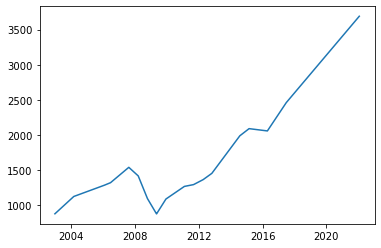

In [28]:
plt.plot(date1,forecast.trend)
# plt.plot(date2,df.y)


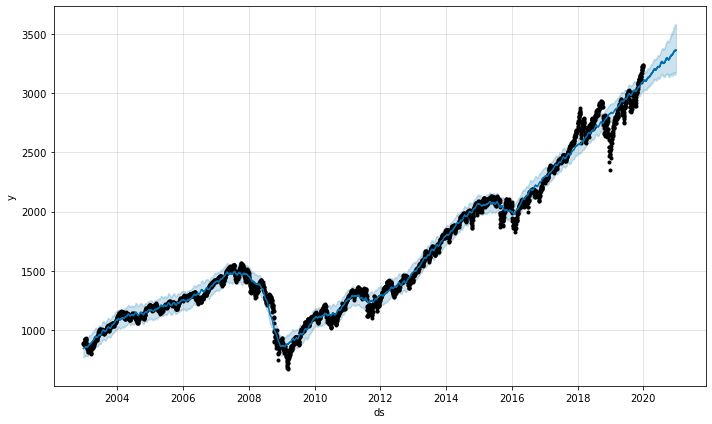

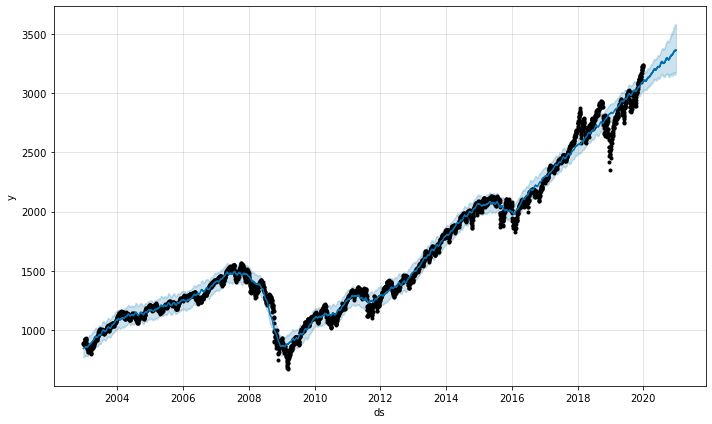

In [40]:
from fbprophet.plot import plot
# A better plot than the simple matplotlib
plot(fbp, forecast)

In [ ]:
def MSE():
    return 1/n * sum()